# Import Dependencies

In [1]:
import pandas as pd
import numpy as np

from config import CSV_FILE_URL
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB

# Read the CSV

In [2]:
# Read the CSV file into a dataframe
df = pd.read_csv(CSV_FILE_URL)
df.shape

(284807, 31)

# Data Cleaning

Checking to see if there are any null values in the dataset. 

In [3]:
# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()
df.shape

(284807, 31)

It could be seen that there are **no null values** in the dataset.

# Data Exploration

Checking Data distribution w.r.t Target feature

In [4]:
df.groupby('Class').count()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Class,,,,,,,,,,,,,,,,,,,,,
0,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,...,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315
1,492,492,492,492,492,492,492,492,492,492,...,492,492,492,492,492,492,492,492,492,492


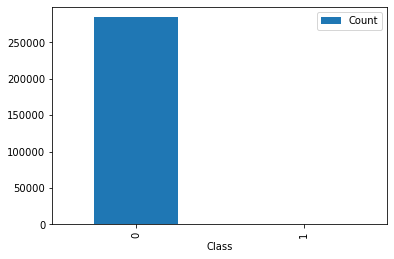

In [5]:
grouped_df = df[['Class','Time']].groupby('Class').count()
grouped_df = grouped_df.rename(columns={"Time":"Count"})
grouped_df.plot(kind="bar")

It is evident from the above plot that data is **highly imbalanced**. The dataset has only 492 fraudulent transactions out of a total of 284,807 transactions, which is a mere **0.17%**.

# Defining features

Defining the predictor features and the target feature.

In [6]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [7]:
# Selecting predictor features. This will be used as x values.
selected_features = df[['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']]
selected_features.shape

(284807, 30)

In [8]:
# Defining predictor and target features to X and y respectively.
# Note: Sklearn requires a two-dimensional array of values
# so we use reshape to create this

X = selected_features
y = df[['Class']].values.reshape(-1, 1)

print("Shape: ", X.shape, y.shape)

Shape:  (284807, 30) (284807, 1)


# Create a Train Test Split

Using `Class` for the y values (target feature)

In [9]:
# Using sklearn's `train_test_split` to split the data into training and testing datasets

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [11]:
print("Shape: ", X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Shape:  (213605, 30) (213605, 1) (71202, 30) (71202, 1)


# Data Pre-processing

Scale the data using the MinMaxScaler

In [12]:
X_minmax = MinMaxScaler().fit(X_train)

X_train_scaled = X_minmax.transform(X_train)
X_test_scaled = X_minmax.transform(X_test)

# Multinomial Naive Bayes Model

### Train the Model

In [13]:
multinomialModel = MultinomialNB()
multinomialModel

MultinomialNB()

In [14]:
multinomialModel.fit(X_train_scaled, y_train.flatten())

MultinomialNB()

In [15]:
print(f"Training Data Score: {multinomialModel.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {multinomialModel.score(X_test_scaled, y_test)}")

Training Data Score: 0.9982256969640224
Testing Data Score: 0.9984129659279234


In [16]:
# Make predictions
multinomialPredictions = multinomialModel.predict(X_test_scaled)

In [17]:
# Print classification report
print(classification_report(y_test.flatten(), multinomialPredictions,
                            target_names=["Non Fraudulent", "Fraudulent"]))

                precision    recall  f1-score   support

Non Fraudulent       1.00      1.00      1.00     71089
    Fraudulent       0.00      0.00      0.00       113

      accuracy                           1.00     71202
     macro avg       0.50      0.50      0.50     71202
  weighted avg       1.00      1.00      1.00     71202



C:\Users\ushaa\anaconda3\envs\PythonData\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Hyperparameter Tuning

Use `GridSearchCV` to tune the model's parameters

In [18]:
multinomialModel.get_params().keys()

dict_keys(['alpha', 'class_prior', 'fit_prior'])

In [19]:
# Create the GridSearchCV model
# Create the GridSearch estimator along with a parameter object containing the values to adjust

multinomialParamGrid = {'alpha': [0, 1, 2, 3],
                        'fit_prior': ['false','true']}
multinomialGrid = GridSearchCV(multinomialModel, multinomialParamGrid, verbose=3)

In [20]:
# Train the model with GridSearch
multinomialGrid.fit(X_train_scaled, y_train.flatten())

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] alpha=0, fit_prior=false ........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\ushaa\anaconda3\envs\PythonData\lib\site-packages\sklearn\naive_bayes.py:512: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
C:\Users\ushaa\anaconda3\envs\PythonData\lib\site-packages\sklearn\naive_bayes.py:512: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
C:\Users\ushaa\anaconda3\envs\PythonData\lib\site-packages\sklearn\naive_bayes.py:512: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV] ............ alpha=0, fit_prior=false, score=0.998, total=   0.1s
[CV] alpha=0, fit_prior=false ........................................
[CV] ............ alpha=0, fit_prior=false, score=0.998, total=   0.1s
[CV] alpha=0, fit_prior=false ........................................
[CV] ............ alpha=0, fit_prior=false, score=0.998, total=   0.1s
[CV] alpha=0, fit_prior=false ........................................
[CV] ............ alpha=0, fit_prior=false, score=0.998, total=   0.1s
[CV] alpha=0, fit_prior=false ........................................


C:\Users\ushaa\anaconda3\envs\PythonData\lib\site-packages\sklearn\naive_bayes.py:512: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\ushaa\anaconda3\envs\PythonData\lib\site-packages\sklearn\naive_bayes.py:512: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\ushaa\anaconda3\envs\PythonData\lib\site-packages\sklearn\naive_bayes.py:512: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\ushaa\anaconda3\envs\PythonData\lib\site-packages\sklearn\naive_bayes.py:512: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV] ............ alpha=0, fit_prior=false, score=0.998, total=   0.1s
[CV] alpha=0, fit_prior=true .........................................
[CV] ............. alpha=0, fit_prior=true, score=0.998, total=   0.1s
[CV] alpha=0, fit_prior=true .........................................
[CV] ............. alpha=0, fit_prior=true, score=0.998, total=   0.1s
[CV] alpha=0, fit_prior=true .........................................


C:\Users\ushaa\anaconda3\envs\PythonData\lib\site-packages\sklearn\naive_bayes.py:512: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\ushaa\anaconda3\envs\PythonData\lib\site-packages\sklearn\naive_bayes.py:512: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\ushaa\anaconda3\envs\PythonData\lib\site-packages\sklearn\naive_bayes.py:512: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV] ............. alpha=0, fit_prior=true, score=0.998, total=   0.1s
[CV] alpha=0, fit_prior=true .........................................
[CV] ............. alpha=0, fit_prior=true, score=0.998, total=   0.1s
[CV] alpha=0, fit_prior=true .........................................
[CV] ............. alpha=0, fit_prior=true, score=0.998, total=   0.1s
[CV] alpha=1, fit_prior=false ........................................
[CV] ............ alpha=1, fit_prior=false, score=0.998, total=   0.1s
[CV] alpha=1, fit_prior=false ........................................
[CV] ............ alpha=1, fit_prior=false, score=0.998, total=   0.1s
[CV] alpha=1, fit_prior=false ........................................
[CV] ............ alpha=1, fit_prior=false, score=0.998, total=   0.1s
[CV] alpha=1, fit_prior=false ........................................
[CV] ............ alpha=1, fit_prior=false, score=0.998, total=   0.0s
[CV] alpha=1, fit_prior=false ........................................
[CV] .

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    2.3s finished
C:\Users\ushaa\anaconda3\envs\PythonData\lib\site-packages\sklearn\naive_bayes.py:512: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


GridSearchCV(estimator=MultinomialNB(),
             param_grid={'alpha': [0, 1, 2, 3], 'fit_prior': ['false', 'true']},
             verbose=3)

In [21]:
print(multinomialGrid.best_params_)
print(multinomialGrid.best_score_)

{'alpha': 0, 'fit_prior': 'false'}
0.9982256969640224


In [22]:
# Make predictions with the hyperparameter tuned model
multinomialGridPredictions = multinomialGrid.predict(X_test_scaled)

In [23]:
# Print classification report
print(classification_report(y_test.flatten(), multinomialGridPredictions,
                            target_names=["Non Fraudulent", "Fraudulent"]))

                precision    recall  f1-score   support

Non Fraudulent       1.00      1.00      1.00     71089
    Fraudulent       0.00      0.00      0.00       113

      accuracy                           1.00     71202
     macro avg       0.50      0.50      0.50     71202
  weighted avg       1.00      1.00      1.00     71202



C:\Users\ushaa\anaconda3\envs\PythonData\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
# Create hyperparameter tuned model with the suggested best params
hypertunedMultinomialModel = MultinomialNB(alpha=0, fit_prior=False)
hypertunedMultinomialModel

MultinomialNB(alpha=0, fit_prior=False)

In [25]:
hypertunedMultinomialModel.fit(X_train_scaled, y_train.flatten())

C:\Users\ushaa\anaconda3\envs\PythonData\lib\site-packages\sklearn\naive_bayes.py:512: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


MultinomialNB(alpha=0, fit_prior=False)

In [26]:
print(f"Training Data Score: {hypertunedMultinomialModel.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {hypertunedMultinomialModel.score(X_test_scaled, y_test)}")

Training Data Score: 0.999218183094965
Testing Data Score: 0.9991292379427544


In [27]:
hypertunedMultinomialModelPredictions = hypertunedMultinomialModel.predict(X_test_scaled)

In [28]:
hypertunedMultinomialModelPredictProba = hypertunedMultinomialModel.predict_proba(X_test_scaled)[:,1]

In [29]:
# Print classification report
print(classification_report(y_test.flatten(), hypertunedMultinomialModelPredictions,
                            target_names=["Non Fraudulent", "Fraudulent"]))

                precision    recall  f1-score   support

Non Fraudulent       1.00      1.00      1.00     71089
    Fraudulent       0.73      0.71      0.72       113

      accuracy                           1.00     71202
     macro avg       0.87      0.85      0.86     71202
  weighted avg       1.00      1.00      1.00     71202



# Gaussian Naive Bayes Model

### Train the Model

In [30]:
gaussianModel = GaussianNB()
gaussianModel

GaussianNB()

In [31]:
gaussianModel.fit(X_train_scaled, y_train.flatten())

GaussianNB()

In [32]:
print(f"Training Data Score: {gaussianModel.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {gaussianModel.score(X_test_scaled, y_test)}")

Training Data Score: 0.9784181081903514
Testing Data Score: 0.9782309485688604


In [33]:
# Make predictions
gaussianPredictions = gaussianModel.predict(X_test_scaled)

In [34]:
# Print classification report
print(classification_report(y_test.flatten(), gaussianPredictions,
                            target_names=["Non Fraudulent", "Fraudulent"]))

                precision    recall  f1-score   support

Non Fraudulent       1.00      0.98      0.99     71089
    Fraudulent       0.06      0.82      0.11       113

      accuracy                           0.98     71202
     macro avg       0.53      0.90      0.55     71202
  weighted avg       1.00      0.98      0.99     71202



### Hyperparameter Tuning

Use `GridSearchCV` to tune the model's parameters

In [35]:
gaussianModel.get_params().keys()

dict_keys(['priors', 'var_smoothing'])

In [36]:
# Create the GridSearchCV model
# Create the GridSearch estimator along with a parameter object containing the values to adjust
gaussianParamGrid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]}
gaussianGrid = GridSearchCV(gaussianModel, gaussianParamGrid, verbose=3)

In [37]:
# Train the model with GridSearch
gaussianGrid.fit(X_train_scaled, y_train.flatten())

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] var_smoothing=1e-09 .............................................
[CV] ................. var_smoothing=1e-09, score=0.978, total=   0.2s
[CV] var_smoothing=1e-09 .............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ................. var_smoothing=1e-09, score=0.979, total=   0.1s
[CV] var_smoothing=1e-09 .............................................
[CV] ................. var_smoothing=1e-09, score=0.980, total=   0.1s
[CV] var_smoothing=1e-09 .............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV] ................. var_smoothing=1e-09, score=0.978, total=   0.1s
[CV] var_smoothing=1e-09 .............................................
[CV] ................. var_smoothing=1e-09, score=0.978, total=   0.1s
[CV] var_smoothing=1e-08 .............................................
[CV] ................. var_smoothing=1e-08, score=0.978, total=   0.2s
[CV] var_smoothing=1e-08 .............................................
[CV] ................. var_smoothing=1e-08, score=0.979, total=   0.1s
[CV] var_smoothing=1e-08 .............................................
[CV] ................. var_smoothing=1e-08, score=0.980, total=   0.1s
[CV] var_smoothing=1e-08 .............................................
[CV] ................. var_smoothing=1e-08, score=0.978, total=   0.2s
[CV] var_smoothing=1e-08 .............................................
[CV] ................. var_smoothing=1e-08, score=0.978, total=   0.1s
[CV] var_smoothing=1e-07 .............................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    7.7s finished


GridSearchCV(estimator=GaussianNB(),
             param_grid={'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05,
                                           0.0001, 0.001, 0.01, 0.1, 1]},
             verbose=3)

In [38]:
print(gaussianGrid.best_params_)
print(gaussianGrid.best_score_)

{'var_smoothing': 0.1}
0.9988857938718663


In [39]:
# Make predictions with the hyperparameter tuned model
gaussianGridPredictions = gaussianGrid.predict(X_test_scaled)

In [40]:
# Print classification report
print(classification_report(y_test.flatten(), gaussianGridPredictions,
                            target_names=["Non Fraudulent", "Fraudulent"]))

                precision    recall  f1-score   support

Non Fraudulent       1.00      1.00      1.00     71089
    Fraudulent       0.70      0.53      0.60       113

      accuracy                           1.00     71202
     macro avg       0.85      0.77      0.80     71202
  weighted avg       1.00      1.00      1.00     71202



In [41]:
# Create the hyperparameter tuned model with the suggested best params 
hypertunedGaussianNBModel = GaussianNB(var_smoothing = 0.1)
hypertunedGaussianNBModel

GaussianNB(var_smoothing=0.1)

In [42]:
hypertunedGaussianNBModel.fit(X_train_scaled, y_train.flatten())

GaussianNB(var_smoothing=0.1)

In [43]:
print(f"Training Data Score: {hypertunedGaussianNBModel.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {hypertunedGaussianNBModel.score(X_test_scaled, y_test)}")

Training Data Score: 0.9988951569485733
Testing Data Score: 0.9988904806044774


In [44]:
hypertunedGaussianNBModelPredictions = hypertunedGaussianNBModel.predict(X_test_scaled)

In [45]:
hypertunedGaussianNBModelPredictProba = hypertunedGaussianNBModel.predict_proba(X_test_scaled)[:,1]

In [46]:
# Print classification report
print(classification_report(y_test.flatten(), hypertunedGaussianNBModelPredictions,
                            target_names=["Non Fraudulent", "Fraudulent"]))

                precision    recall  f1-score   support

Non Fraudulent       1.00      1.00      1.00     71089
    Fraudulent       0.70      0.53      0.60       113

      accuracy                           1.00     71202
     macro avg       0.85      0.77      0.80     71202
  weighted avg       1.00      1.00      1.00     71202



# Bernoulli Naive Bayes Model

### Train the Model

In [47]:
bernoulliModel = BernoulliNB()
bernoulliModel

BernoulliNB()

In [48]:
bernoulliModel.fit(X_train_scaled, y_train.flatten())

BernoulliNB()

In [49]:
print(f"Training Data Score: {bernoulliModel.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {bernoulliModel.score(X_test_scaled, y_test)}")

Training Data Score: 0.9982303785023758
Testing Data Score: 0.9984270104772338


In [50]:
# Make predictions with the model
bernoulliPredictions = bernoulliModel.predict(X_test_scaled)

In [51]:
bernoulliPredictProba = bernoulliModel.predict_proba(X_test_scaled)[:,1]

In [52]:
# Print classification report
print(classification_report(y_test.flatten(), bernoulliPredictions,
                            target_names=["Non Fraudulent", "Fraudulent"]))

                precision    recall  f1-score   support

Non Fraudulent       1.00      1.00      1.00     71089
    Fraudulent       1.00      0.01      0.02       113

      accuracy                           1.00     71202
     macro avg       1.00      0.50      0.51     71202
  weighted avg       1.00      1.00      1.00     71202



# Compare the Metrics of the models

Bernoulli Naive Bayes
Accuracy:  0.9984270104772338
Precision:  1.0
Recall:  0.008849557522123894
F1-Score:  0.017543859649122806
AUC score:  0.504424778761062
                precision    recall  f1-score   support

Non Fraudulent       1.00      1.00      1.00     71089
    Fraudulent       1.00      0.01      0.02       113

      accuracy                           1.00     71202
     macro avg       1.00      0.50      0.51     71202
  weighted avg       1.00      1.00      1.00     71202



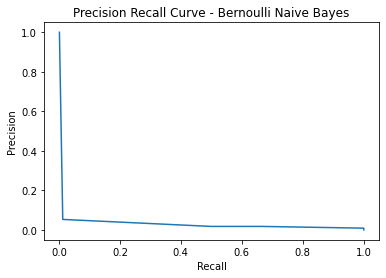

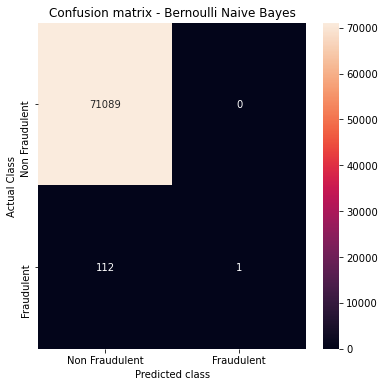

In [53]:
print("Bernoulli Naive Bayes")
print("======================")
print("Accuracy: ",accuracy_score(y_test.flatten(), bernoulliPredictions)) 
print("Precision: ",precision_score(y_test.flatten(), bernoulliPredictions))
print("Recall: ",recall_score(y_test.flatten(), bernoulliPredictions))
print("F1-Score: ",f1_score(y_test.flatten(), bernoulliPredictions))
print("AUC score: ",roc_auc_score(y_test.flatten(), bernoulliPredictions))
print(classification_report(y_test.flatten(), bernoulliPredictions,
                            target_names=["Non Fraudulent", "Fraudulent"]))

p, r, t = precision_recall_curve(y_test.flatten(), bernoulliPredictProba)
plt.plot(p, r)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve - Bernoulli Naive Bayes')

confusionMatrix = confusion_matrix(y_test.flatten(), bernoulliPredictions) 
plt.figure(figsize =(6, 6)) 
sns.heatmap(confusionMatrix, xticklabels = ['Non Fraudulent', 'Fraudulent'],  
            yticklabels = ['Non Fraudulent', 'Fraudulent'], annot = True, fmt ="d"); 
plt.title("Confusion matrix - Bernoulli Naive Bayes") 
plt.ylabel('Actual Class') 
plt.xlabel('Predicted class') 
plt.show()

Gaussian Naive Bayes
Accuracy:  0.9988904806044774
Precision:  0.6976744186046512
Recall:  0.5309734513274337
F1-Score:  0.6030150753768845
AUC score:  0.7653038563027749
                precision    recall  f1-score   support

Non Fraudulent       1.00      1.00      1.00     71089
    Fraudulent       0.70      0.53      0.60       113

      accuracy                           1.00     71202
     macro avg       0.85      0.77      0.80     71202
  weighted avg       1.00      1.00      1.00     71202



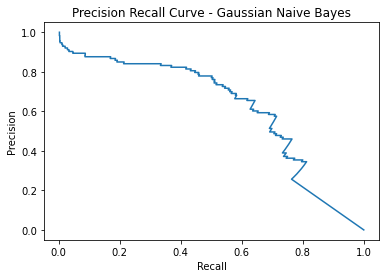

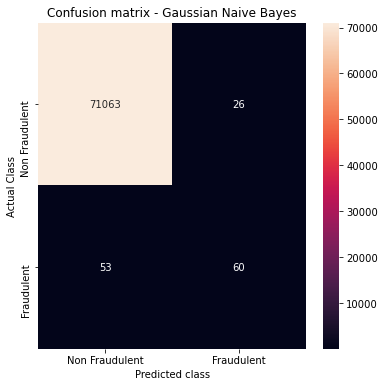

In [54]:
print("Gaussian Naive Bayes")
print("====================")
print("Accuracy: ",accuracy_score(y_test.flatten(), hypertunedGaussianNBModelPredictions)) 
print("Precision: ",precision_score(y_test.flatten(), hypertunedGaussianNBModelPredictions))
print("Recall: ",recall_score(y_test.flatten(), hypertunedGaussianNBModelPredictions))
print("F1-Score: ",f1_score(y_test.flatten(), hypertunedGaussianNBModelPredictions))
print("AUC score: ",roc_auc_score(y_test.flatten(), hypertunedGaussianNBModelPredictions))
print(classification_report(y_test.flatten(), hypertunedGaussianNBModelPredictions,
                            target_names=["Non Fraudulent", "Fraudulent"]))

p, r, t = precision_recall_curve(y_test.flatten(), hypertunedGaussianNBModelPredictProba)
plt.plot(p, r)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve - Gaussian Naive Bayes')

confusionMatrix = confusion_matrix(y_test.flatten(), hypertunedGaussianNBModelPredictions) 
plt.figure(figsize =(6, 6)) 
sns.heatmap(confusionMatrix, xticklabels = ['Non Fraudulent', 'Fraudulent'],  
            yticklabels = ['Non Fraudulent', 'Fraudulent'], annot = True, fmt ="d"); 
plt.title("Confusion matrix - Gaussian Naive Bayes") 
plt.ylabel('Actual Class') 
plt.xlabel('Predicted class') 
plt.show() 

Multinomial Naive Bayes
Accuracy:  0.9991292379427544
Precision:  0.7339449541284404
Recall:  0.7079646017699115
F1-Score:  0.7207207207207207
AUC score:  0.853778331213136
                precision    recall  f1-score   support

Non Fraudulent       1.00      1.00      1.00     71089
    Fraudulent       0.73      0.71      0.72       113

      accuracy                           1.00     71202
     macro avg       0.87      0.85      0.86     71202
  weighted avg       1.00      1.00      1.00     71202



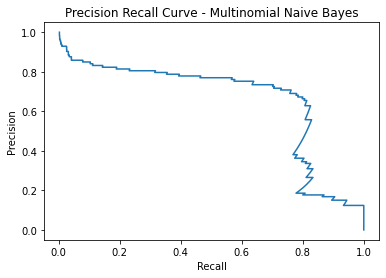

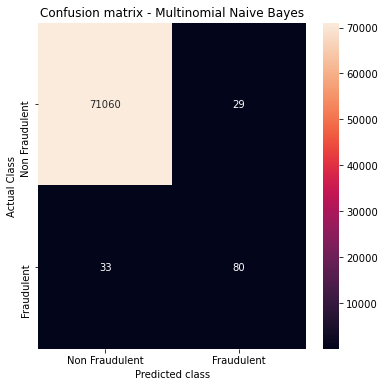

In [55]:
print("Multinomial Naive Bayes")
print("=======================")
print("Accuracy: ",accuracy_score(y_test.flatten(), hypertunedMultinomialModelPredictions)) 
print("Precision: ",precision_score(y_test.flatten(), hypertunedMultinomialModelPredictions))
print("Recall: ",recall_score(y_test.flatten(), hypertunedMultinomialModelPredictions))
print("F1-Score: ",f1_score(y_test.flatten(), hypertunedMultinomialModelPredictions))
print("AUC score: ",roc_auc_score(y_test.flatten(), hypertunedMultinomialModelPredictions))
print(classification_report(y_test.flatten(), hypertunedMultinomialModelPredictions,
                            target_names=["Non Fraudulent", "Fraudulent"]))

p, r, t = precision_recall_curve(y_test.flatten(), hypertunedMultinomialModelPredictProba)
plt.plot(p, r)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve - Multinomial Naive Bayes')

confusionMatrix = confusion_matrix(y_test.flatten(), hypertunedMultinomialModelPredictions) 
plt.figure(figsize =(6, 6)) 
sns.heatmap(confusionMatrix, xticklabels = ['Non Fraudulent', 'Fraudulent'],  
            yticklabels = ['Non Fraudulent', 'Fraudulent'], annot = True, fmt ="d"); 
plt.title("Confusion matrix - Multinomial Naive Bayes") 
plt.ylabel('Actual Class') 
plt.xlabel('Predicted class') 
plt.show() 